#Algoritmo genético para la optimización de la distribución de plantación
El objetivo del algoritmo genético es servir como metaheurístico para conseguir una solución factible que minimize el nivel de competencia en un terreno diario. El sistema cuenta con las siguientes restricciones:


1.   El terreno es cuadrículado y de largo *M*, con una cantidad de surcos por linea *N*. Por lo tanto la cantidad de surcos en el terreno es de *N x N*
2.   Para cada especie de planta existe una cantidad que debe de ser respetada dentro del terreno. Si la solución del cromosoma NO cumple con esta condición se le obliga a hacerlo
3.  La competencia de una planta está determinada por las plantas que existen de manera adyacente a ella
4. Las plantas nativas a un terreno NUNCA cambian de posición o especie
**Consideraciones no contempladas todavía: **

1.   Existen plantas nativas en el terreno y son generadas  en base a distribuciones exponenciales

##Algoritmo Genético
Para simplificar el algoritmo genético se generará una clase de objeto "Planta" la cual guardará atributos importantes sobre las plantas que hay en cada surco.

###Clase Planta
Cada objeto planta guarda los siguientes atributos:
*   Especie: La especie a la que pertence la planta (se representará en base a un código numérico)
*   Posicion: Posición en la que se encuentra dentro del cromosoma
*   Vecinos: Lista de posiciones de sus plantas colindantes
Para los valores de posiciones y vecinos se usará un parámetro de entrada de largo del grafo *N* y en base a este parámetro se determinará el tamaño del cromosoma y las posiciones vecinas
###Parámetros del algoritmo genético

*   **Tipo de cromosoma**: Cada posición i-ésima del cromosoma representa un objeto **planta** del surco *i*. Las posiciones se cuentan de izquierda a derecha y de arriba a abajo.
*   **Longitud del cromosoma:** La longitud del cromosoma es equivalente a la cantidad de surcos en el terreno (N*N).
*   **Criterio de inicialización:** Dada una secuencia de plantación de tipo cromosoma que considera una distribución se genera una permutación y se obliga a que las plantas nativas permanezcan en su lugar
*   **Criterio de infactibilidad:** El cromosoma será infactible la distribución de plantas no se cumple.
*   **Crietrio de paro:** Número de generaciones especificadas
*   **Fitness:** El fitness es calculado como el inverso del total de la competencia en el sistema.
*   **Tamaño de la población:** 50 individuos
*   **Probabilidad de cruce:** Los individuos tienen una probabilidad de ser seleccionado como padres proporcionales al valor de su función fitness comparado con la suma de los valores fitness de todos los demás individuos de la población.
*   **Punto de cruce:** Existe un único punto de cruce
*   **Lugar de cruce:** El lugar de cruce es la mitad del cromosoma
*   **Probabilidad de mutación:** 0.1
*   **Criterio de reemplazo:** Cada generación serán eliminados la mitad de individuos con peor fitness






#Parametros
En base a la información proporcionada en el reto, el No. de plantas por hectarea es de 658. Si se simplifica el modelo para una Ha. la cantidad de plantas resultante de del cuadrado de un número es 26^2= 676. De esta manera:


*   Largo del terreno: 26 surcos
*   Cantidad de surcos: 676

Especie            | Codigo de especie |
-------------------|-------------------
Agave Lechugilla         | 1
Agave salmiana          | 2
Agave scabra             | 3  
Agave striata             |4  
Opuntia Cantabrigiensis | 5   
Opuntia engelmannii      | 6  
Opuntia robusta      | 7       
Opuntia strptacantha      | 8
Prosopis laevigata       | 9  
Yucca filifera       | 10    


In [17]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

##Definicion de clases

In [18]:
class Plant:
  def __init__(self, species):
    self.species=species
  def set_position_get_neighbours(self, position, terrain_n):
      self.position=position
      neighbours=[]
      neighbours.extend([position-terrain_n, position-1, position+1, position+terrain_n])
      chromo= (terrain_n**2)-1
      items_to_remove=[]
      for i in range(len(neighbours)):
        #Primer condicional: Elimina vecinos fuera de la dimensión del tereno
        if (neighbours[i]<0 or neighbours[i]>chromo):
          items_to_remove.append(neighbours[i])
        #Segundo condicional: Elimina vecinos laterales cuando el vecino se encuentra en otra fila del terreno
        elif (abs(self.position-neighbours[i])==1) and (self.position//terrain_n!=neighbours[i]//terrain_n):
          items_to_remove.append(neighbours[i])
      neighbours=list(set(neighbours)-set(items_to_remove))
      self.neighbours_indexes=neighbours

class Chromosome:
    def __init__(self, distribution, terrain_n, competition_matrix, native_list, cromo=None, shuffle=False, fitness_penalization_value=4):
      size=terrain_n**2
      self.distribution=distribution
      #En caso de inciar la población se realiza una permutación de un arreglo que satisface la distribución de especies
      if shuffle==True:
        base=[]
        native_indexes=[]
        #Se ajusta la distribución considerando las plantas nativas y se guarda su índice para su inserción al cromosoma en la posición indicada
        for i in range(len(native_list)):
          native_type=native_list[i][1]
          self.distribution[native_type-1]-=1
          native_indexes.append(native_list[i][0])

        #Se genera una base que cumple con la distribución considerando también las plantas nativas
        for i in range(len(self.distribution)):
          for j in range(self.distribution[i]):
            base.append(Plant(i+1))
            #Se mezclan los valores de la base
            random.shuffle(base)
        chromosome=[]
        base_index=0
        aux=0
        for i in range(size):
          #Caso 1: La posición i cuenta con una planta nativa y se respeta su posición y especie
          if i in native_indexes:
            chromosome.append(Plant(native_list[aux][1]))
            aux+=1
          #Caso 2: La posición i no cuenta con una planta nativa -> se asigna una planta que cumpla la distribución de especies
          elif i not in native_indexes:
            chromosome.append(base[base_index])
            base_index+=1
        #Se asigna el cromosoma como valor propio de objeto
        self.chromosome=chromosome
        for i in range(len(native_list)):
          native_type=native_list[i][1]
          self.distribution[native_type-1]+=1
      #Si shuffle = False, sólo se verifica que la distribución de las plantas nativas se haya respetado
      else:
        native_indexes=[]
        for i in range((len(native_list))):
          native_indexes.append(native_list[i][0])
        aux=0
        for i in range(size):
          if i in native_indexes:
            cromo[i]=Plant(native_list[aux][1])
            aux+=1
        chromosome= self.back_to_factibility(cromo, native_indexes)
        self.chromosome=chromosome

      #se inicializa una lista de la distribución de especies para un acceso sencillo a los valores y no a las instancias de objetos
      species_distribution_list=[]
      #Se inicializan los parámetros secundarios de cada planta: Posición e índice de los vecinos
      for i in range(len(self.chromosome)):
        self.chromosome[i].set_position_get_neighbours(i, terrain_n)
        species_distribution_list.append(self.chromosome[i].species)
      # Se calculan la competencia total en el cromosoma (violaciones)
      self.violations= self.get_total_competition(competition_matrix)
      #Se calcula el fitness del cromosoma (si el cromosoma se inició como permutación la fórmula se simplifica)
      if shuffle==True:
        self.fitness= 1/(self.violations+1)
      else:
        infactibility=0
        for i in range(len(distribution)):
          if species_distribution_list.count(i+1)!=distribution[i]:
            infactibility+= abs(species_distribution_list.count(i)-distribution[i])
        self.fitness= 1/(self.violations+(infactibility*fitness_penalization_value)+1)
      self.species_distribution_list=species_distribution_list
    #Funciones Auxiliares que servirán para saber el valor de competencia real en el cromosoma
    def get_total_competition(self, competition_matrix):
      total_competition=0
      for i in range(len(self.chromosome)):
          for j in range(len(self.chromosome[i].neighbours_indexes)):
            arc_competition=competition_matrix[(self.chromosome[i].species)-1][(self.chromosome[self.chromosome[i].neighbours_indexes[j]].species)-1]
            total_competition+=arc_competition
      total_competition=total_competition/2
      self.competition=total_competition
      return total_competition

    def back_to_factibility(self, cromo, native_list):
        #Se realiza una tabla de distribución que se deberá de balancear para asegurar la distribución estipulada
        balance_toy=self.distribution.copy()
        for i in range(len(cromo)):
          species_index=cromo[i].species-1
          balance_toy[species_index]-=1
        under_represented_indexes= [index for index, value in enumerate(balance_toy) if value >0]
        if len(under_represented_indexes)==0:
          return cromo
        for i in range(len(cromo)):
          current_species_index= cromo[i].species-1
          if balance_toy[current_species_index]<0 and i not in native_list:
            random_index = random.randint(0, len(under_represented_indexes) - 1)
            cromo[i]=Plant(under_represented_indexes[random_index]+1)
            balance_toy[current_species_index]+=1
            balance_toy[under_represented_indexes[random_index]]-=1
            under_represented_indexes= [index for index, value in enumerate(balance_toy) if value >0]

        return cromo

# Codificación del algoritmo genético

In [19]:
def initialize_population(n, distribution, terrain_n, competition_matrix, native_list):
  population=[]
  for _ in range(n):
    population.append(Chromosome(distribution, terrain_n, competition_matrix, native_list, shuffle=True))
  return population
def selection(population):
  total_fitness = sum(individual.fitness for individual in population)
  probabilities = [individual.fitness / total_fitness for individual in population]
  parents = random.choices(population, weights=probabilities, k=2)
  return parents
def mutation(chromosome, mutation_probability):
  for i in range(len(chromosome)):
    if random.random() <= mutation_probability:
      random_num = random.randint(1, len(distribution))
      chromosome[i] = Plant(random_num)
  return chromosome
def crossover(parents, mutation_probability, distribution, terrain_n, competition_matrix, native_list):
  cross_p =int(len(parents[0].chromosome)//2)
  parent1=list(parents[0].chromosome)
  parent2=list(parents[1].chromosome)
  chromosome1=parent1[:cross_p] + parent2[cross_p:]
  chromosome2=parent2[:cross_p] + parent1[cross_p:]
  chromosome1=mutation(chromosome1, mutation_probability)
  chromosome2=mutation(chromosome2, mutation_probability)
  child1 = Chromosome(distribution, terrain_n, competition_matrix, native_list, cromo=chromosome1)
  child2 = Chromosome(distribution, terrain_n, competition_matrix, native_list, cromo=chromosome2)
  childs=[child1,child2]
  return childs
def replace_population(population, offspring):
  population_size = len(population)
  population.extend(offspring)
  population.sort(key=lambda x: x.fitness, reverse=True)
  return population[:population_size]
def Plantacion_genetico(pop_size, num_generations,mutation_probability, distribution, terrain_n, competition_matrix, native_list, verbose=False):
  population = initialize_population(pop_size, distribution, terrain_n, competition_matrix, native_list)
  best_solution = max(population, key=lambda x: x.fitness)
  if verbose==True:
    for generation in range(num_generations):
      new_population = []
      while len(new_population) < pop_size:
        parents = selection(population)
        offspring = crossover(parents, mutation_probability, distribution, terrain_n, competition_matrix, native_list)
        new_population.extend(offspring)
      population = replace_population(population, new_population)
      current_best = max(population, key=lambda x: x.fitness)
      if current_best.fitness > best_solution.fitness:
        best_solution = current_best
      print(f"Generation {generation + 1} Best individual has a competition Cost of: {best_solution.violations}")
  else:
    for generation in range(num_generations):
      new_population = []
      while len(new_population) < pop_size:
        parents = selection(population)
        offspring = crossover(parents, mutation_probability, distribution, terrain_n, competition_matrix, native_list)
        new_population.extend(offspring)
      population = replace_population(population, new_population)
      current_best = max(population, key=lambda x: x.fitness)
      if current_best.fitness > best_solution.fitness:
        best_solution = current_best
  return best_solution

#Codifiicación de la distribución de especies nativas

In [20]:
random.seed(73)
dimensiones = (26, 26)
requisitos= [43,201,43,43,50,40,75,66,88,27]


# -------------------------------------- Montecarlo --------------------------------------
muestras_raw = [[ 8,  58,  66,  10,  65,  67,  41,  32,  58, 47, 48, 36, 50, 35, 40, 70, 56, 45, 56, 69, 54, 75, 44, 10, 44, 72, 74, 67, 60, 34],
                [46, 263, 236,  52, 280, 306, 209, 252, 269, 209, 233, 182, 189, 186, 311, 290, 233, 204, 223, 285, 287,	292, 288, 59, 155, 291, 342, 309, 280, 195],
                [16,  47,  51,	15,	 66,  63,  43,	46,	 58,  47,	41,	43,	49,	38,	52,	55,	39,	34,	51,	57,	70,	60,	69,	15,	28,	73,	52,	67,	61,	56],
                [16,  49,  50,	 9,	 61,  61,  49,	40,	 53,  41,	37,	44,	28,	43,	62,	54,	46,	33,	48,	75,	62,	68,	51,	11,	31,	50,	55,	66,	53,	58],
                [11,  60,  71,	15,	 92,  81,  48,	73,	 57,  66,	48,	51,	43,	39,	68,	84,	71,	56,	50,	77,	89,	104,	69,	17,	39,	66,	70,	86,	76,	55],
                [14,  44,  56,	10,	 54,  62,  52,	39,	 58,  43,	40,	41,	33,	44,	63,	50,	45,	46,	48,	74,	58,	62,	60,	18,	39,	62,	76,	54,	68,	46],
                [18, 111, 100,	18,	124, 118,  87,	86,	 94,  96,	94,	68,	73,	73,	132,	105,	83,	82,	93,	107,	126,	109,	122,	17,	65,	125,	100,	120,	109,	91],
                [12,  95,  78,	20,	114,  91,  60,	79,	 91,  71,	65,	72,	76,	61,	89,	77,	81,	48,	90,	103,	109,	95,	100,	10,	50,	101,	100,	103,	85,	63],
                [15,  98, 123,	23,	106, 133,  97,  91,	117, 108,	94,	67,	97,	74,	149,	121,	97,	95,	120,	104,	139,	125,	106,	39,	67,	122,	129,	141,	135,	86],
                [ 9,  39,  28,	11,  41,  45,  27,  26,  37,  29, 27, 19, 25, 23, 53, 40, 32, 17, 33, 25, 44, 43, 39, 8, 25, 31, 44, 33, 36, 23]]

muestras = muestras_raw
t_muestra = [1.28, 6.64, 6.76, 1.38, 8, 7.82, 5.53, 5.64, 7.11, 6.11, 5.64, 4.92, 05.05, 4.75, 7.97, 7.34, 5.98, 5.4, 6.28, 7.6, 8, 8, 7.67, 1.47, 4.19, 7.52, 8, 8, 7.56, 5.4]
# Normalizar las muestras a 1 hectárea
for j in range(len(t_muestra)):
    for i in range(len(muestras_raw)):
        muestras[i][j] = muestras_raw[i][j] / t_muestra[j]

def generaMapaPoisson(m):
    # Inicializar mapa de -1's
    mapa = (np.ones(dimensiones).astype(int) * (-1)).tolist()
    # Calcular las medias de cada especie
    medias = [sum(i)/len(i) for i in m]
    # Número de plantas por especie
    # num_p = [min(np.random.poisson(lam = media), requisitos[]) for media in medias]
    num_p = []
    for i in range(len(medias)):
        aux = min(np.random.poisson(lam = medias[i]), requisitos[i])
        num_p.append(aux)
    # Lista con todas las posibles posiciones de plantas
    espacios = [(p, q) for p in range(dimensiones[0]) for q in range(dimensiones[1])]

    # Lista de plantas que ya estaban plantadas
    plantas = []
    for i in range(len(num_p)):
        # Ir añandiendo tantos i como plantas de esa especie
        plantas += (np.ones(num_p[i]).astype(int) * i).tolist()

    # Elegir posiciones fijas al azar
    elegidas = random.choices(population = espacios, k = len(plantas))

    for i in range(len(plantas)):
        mapa[elegidas[i][0]][elegidas[i][1]] = plantas[i]

    return mapa, num_p
mapa, num_p = generaMapaPoisson(muestras)
def native_distribution(mapa):
  flattened_list = []
  #Dada la función de distribución implementada por Juan José Beltran se adaptan los resultados de la simulación de plantas al formato utilizado por el algoritmo genético
  for sublist in mapa:
    # Extend the flattened list with elements from the current sublist
    flattened_list.extend(sublist)
  native_species = [[index, value+1] for index, value in enumerate(flattened_list) if value != -1]
  return native_species


Función de visualización de resultados

In [21]:
def create_heatmap(data, validation_length):
    if len(data) != validation_length**2:
        raise ValueError("Data must contain exactly ",validation_length**2 , " elements.")
    matrix = np.array(data).reshape((validation_length, validation_length))

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="gist_earth", cbar=True)
    plt.title("Distribución de siembra")
    plt.show()

def neighbor_probabilities(data, validation_length, show=False):
    matrix = np.array(data).reshape((validation_length, validation_length))
    n=validation_length
    unique_elements = sorted(set(element for row in matrix for element in row))
    element_index = {element: idx for idx, element in enumerate(unique_elements)}
    probabilities = np.zeros((len(unique_elements), len(unique_elements)))
    total_neighbors = defaultdict(int)

    for i in range(n):
        for j in range(n):
            current_value = matrix[i][j]
            neighbors = []
            if i > 0:  # Up
                neighbors.append(matrix[i-1][j])
            if i < n - 1:  # Down
                neighbors.append(matrix[i+1][j])
            if j > 0:  # Left
                neighbors.append(matrix[i][j-1])
            if j < n - 1:  # Right
                neighbors.append(matrix[i][j+1])

            for neighbor in neighbors:
                probabilities[element_index[current_value]][element_index[neighbor]] += 1
                total_neighbors[current_value] += 1

    # Convert counts to probabilities
    for element in unique_elements:
        idx = element_index[element]
        if total_neighbors[element] > 0:
            probabilities[idx] /= total_neighbors[element]
    if show==True:
      plt.figure(figsize=(10, 8))
      sns.heatmap(probabilities, xticklabels=unique_elements, yticklabels=unique_elements, annot=True)
      plt.title('Plant Probability Heatmap')
      plt.show()
    return probabilities


In [22]:
competition_matrix = np.array([
    [0, 6, 7, 5, 4, 5, 6, 4, 8, 7],  # Agave lechuguilla        [0][:] -> Codigo de especie: 1
    [6, 0, 8, 7, 5, 6, 7, 5, 9, 8],  # Agave salmiana           [1][:] -> Codigo de especie: 2
    [7, 8, 0, 7, 5, 6, 6, 5, 8, 7],  # Agave scabra             [2][:] -> Codigo de especie: 3
    [5, 7, 7, 0, 4, 5, 6, 4, 8, 6],  # Agave striata            [3][:] -> Codigo de especie: 4
    [4, 5, 5, 4, 0, 7, 7, 7, 6, 5],  # Opuntia cantabrigiensis  [4][:] -> Codigo de especie: 5
    [5, 6, 6, 5, 7, 0, 8, 8, 6, 6],  # Opuntia engelmannii      [5][:] -> Codigo de especie: 6
    [6, 7, 6, 6, 7, 8, 0, 8, 7, 6],  # Opuntia robusta          [6][:] -> Codigo de especie: 7
    [4, 5, 5, 4, 7, 8, 8, 0, 6, 5],  # Opuntia streptacantha    [7][:] -> Codigo de especie: 8
    [8, 9, 8, 8, 6, 6, 7, 6, 0, 8],  # Prosopis laevigata       [8][:] -> Codigo de especie: 9
    [7, 8, 7, 6, 5, 6, 6, 5, 8, 0],  # Yucca filifera           [9][:] -> Codigo de especie: 10
])
terrain_length= 26
distribution= [43,201,43,43,50,40,75,66,88,27]
native_list= native_distribution(mapa) #Cada lista (o tupla) dentro de la lista se lee así: [[#Surco, Código_especie]]
population = 50
num_generations = 100
mutation_probability = 0.1

#Simulación de Montecarlo

In [23]:
#Función auxiliar para sacar la matriz de transición promedio
def average_matrix(matrices):
    average_matrix = np.mean(matrices, axis=0)
    return average_matrix

----------------Iteration  1  --------------------
Best Solution Cost: 6045.0
----------------Iteration  2  --------------------
Best Solution Cost: 5969.0
----------------Iteration  3  --------------------
Best Solution Cost: 5924.0
----------------Iteration  4  --------------------
Best Solution Cost: 6032.0
----------------Iteration  5  --------------------
Best Solution Cost: 6078.0
----------------Iteration  6  --------------------
Best Solution Cost: 6006.0
----------------Iteration  7  --------------------
Best Solution Cost: 5943.0
----------------Iteration  8  --------------------
Best Solution Cost: 5936.0
----------------Iteration  9  --------------------
Best Solution Cost: 5982.0
----------------Iteration  10  --------------------
Best Solution Cost: 5968.0
----------------Iteration  11  --------------------
Best Solution Cost: 6042.0
----------------Iteration  12  --------------------
Best Solution Cost: 5994.0
----------------Iteration  13  --------------------
Best Solu

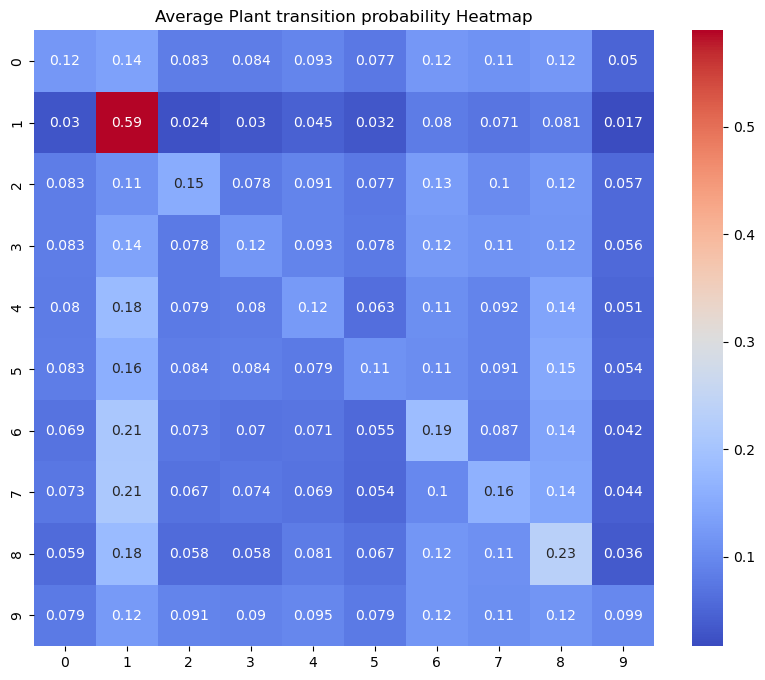

In [24]:
iterations= 1000
solution_costs=[]
plant_transitions=[]
for i in range(iterations):
  native_list= native_distribution(mapa) #Cada lista (o tupla) dentro de la lista se lee así: [[#Surco, Código_especie]]
  print("----------------Iteration ", i+1, " --------------------")
  best_solution= Plantacion_genetico(population, num_generations, mutation_probability, distribution, terrain_length, competition_matrix, native_list)
  print("Best Solution Cost:", best_solution.competition)
  p = neighbor_probabilities(best_solution.species_distribution_list, terrain_length)
  solution_costs.append(best_solution.competition)
  plant_transitions.append(p)
transition_average= average_matrix(plant_transitions)
print("\n\n\nSIMULATION ENDED")
print("Average best solution cost: ", sum(solution_costs)/len(solution_costs))
plt.figure(figsize=(10, 8))
sns.heatmap(transition_average, annot=True, cmap='coolwarm')
plt.title('Average Plant transition probability Heatmap')
plt.show()



#Ejemplo de distribución

Ejemplo de distribución


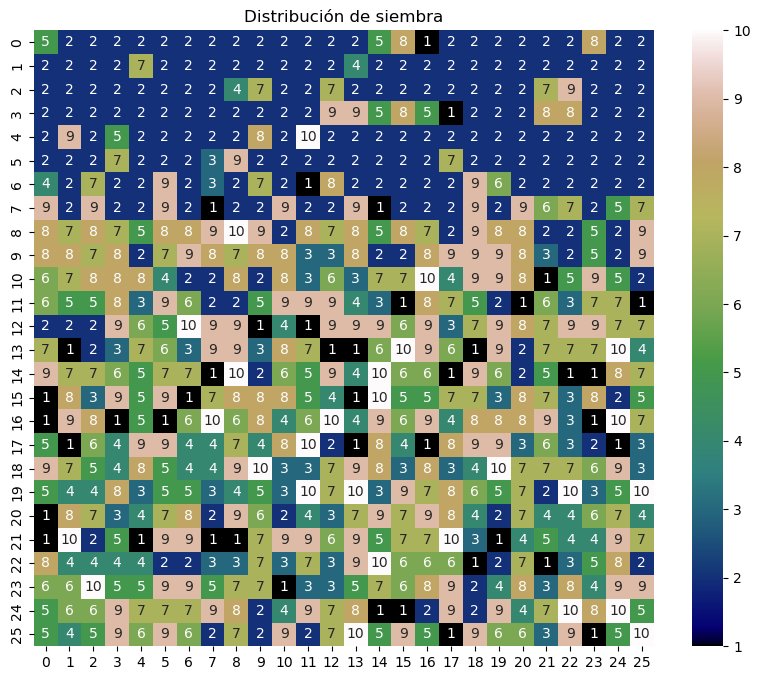

In [25]:
print("Ejemplo de distribución")
create_heatmap(best_solution.species_distribution_list, terrain_length)